In [7]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [8]:
from micrograd.engine import Value
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [9]:
class Value:
    def __init__(self, data, _children=(), _op='', label=""):
        self.data = data
        self._prev = set(_children) # _children -> tuple, set of tuples
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data={self.data})"
        
    def __add__(self, other):

        if not isinstance(other, Value):
            other = Value(other)
            
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        
        return out

    def __mul__(self, other):

        if not isinstance(other, Value):
            other = Value(other)
            
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        
        return out


    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supports int/float"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * self.data ** (other-1) * out.grad
        out._backward = _backward
        
        return out
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
            self.grad = (1 - t**2) * out.grad
            
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward


    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    def __truediv__(self, other):
        return self * other**-1
        
    def __neg__(self):
        return self * -1
        
    def __sub__(self, other):
        return self + (-other)
        
    def __rmul__(self, other):
        return self * other
        
    def __radd__(self, other):
        return self + other

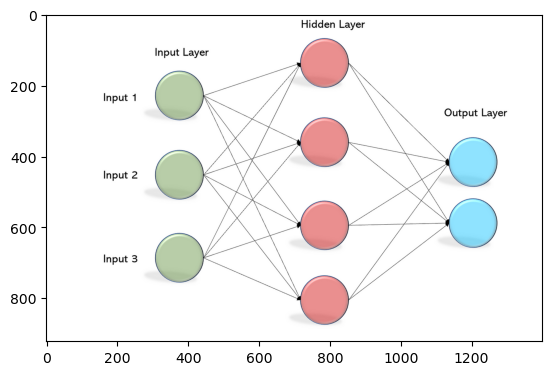

In [10]:
import matplotlib.image as mpimg
image = mpimg.imread("mlp.png")
plt.imshow(image)
plt.show()

In [11]:
class Neuron: 

    def __init__(self, nin):
        # w -> randomly generated weights
        # b -> bias
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w * x + b
        # sum(iterations, start(start at bias instead of 0))
        #print(len(x))
        #print("weights:",len(self.w))
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()

        return out
        
    def parameters(self):
        return self.w + [self.b]
        
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        # calls n(x) for each neuron in layer -> putting x into each neuron and storing results
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
        
    def parameters(self):
        params = []
        for neuron in self.neurons:
            local_params = neuron.parameters()
            params.extend(local_params)
        return params
        
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = []
        
        for i in range(len(nouts)):
            #print(sz[i], sz[i+1])
            self.layers.append(Layer(sz[i], sz[i+1]))
            # i becomes num of input, i+1 is number of output

        #self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def parameters(self):
        params = []
        for layer in self.layers:
            layer_params = layer.parameters()
            params.extend(layer_params)
        
        return params
        
    def __call__(self, x):
        for layer in self.layers:
           #print(len(x))
            #print(x)
            x = layer(x)
        return x
    
        

In [12]:
x = [2.0, 3.0, -1.0]
nn = MLP(3,[4,4,1])
out = nn(x)

In [13]:
nn.parameters()

[Value(data=0.8973962330576697),
 Value(data=-0.14585796498201886),
 Value(data=-0.7308517288136709),
 Value(data=0.5343184389613806),
 Value(data=-0.9236420909513345),
 Value(data=-0.18046645223069024),
 Value(data=-0.7195886052390024),
 Value(data=-0.10483320395504148),
 Value(data=0.27454362799401877),
 Value(data=0.2634748329902179),
 Value(data=0.6247059232037047),
 Value(data=-0.41970051541987363),
 Value(data=0.11561619346376895),
 Value(data=-0.8738724628569023),
 Value(data=0.8917704777651345),
 Value(data=0.6981644764162749),
 Value(data=0.028962654473361438),
 Value(data=0.82973757057676),
 Value(data=0.8919761262254808),
 Value(data=-0.676329782460904),
 Value(data=0.7440515084954566),
 Value(data=0.0011398229971908425),
 Value(data=0.5466289574031074),
 Value(data=0.23254402036458743),
 Value(data=-0.9676256758487654),
 Value(data=0.005187839444056763),
 Value(data=-0.017022654508980217),
 Value(data=-0.2467510370887107),
 Value(data=-0.06467466960693424),
 Value(data=0.20

In [14]:
# tiny dataset
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [15]:
ypred = [nn(x) for x in xs]
ypred

[Value(data=-0.6661420369396146),
 Value(data=-0.1189661959727495),
 Value(data=-0.46183110671674465),
 Value(data=-0.6709627928284373)]

In [16]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=6.633992263810751)

In [17]:
nn.layers[0].neurons[0].w[0].grad

0.0

In [18]:
nn.layers[0].neurons[0].w[0].data

0.8973962330576697

In [19]:
loss.backward()

In [20]:
for p in nn.parameters():
    p.data += +0.01 * p.grad

In [21]:
ypred = [nn(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=7.1432740189946315)

In [22]:
ypred

[Value(data=-0.7292137775753685),
 Value(data=-0.08674334288950164),
 Value(data=-0.43328388191427036),
 Value(data=-0.7314412638560264)]

In [23]:

# Training loop
epoch = 10
step = -0.01
for k in range(epoch):

    # forward pass
    ypred = [nn(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

    # zero grad
    for p in nn.parameters():
        p.grad = 0.0
    
    # backward pass
    loss.backward()

    # Update
    for p in nn.parameters():
        p.data += -0.01 * p.grad

    print("epoch: ",k, "loss: ",loss.data)
    

epoch:  0 loss:  7.1432740189946315
epoch:  1 loss:  6.680932818030314
epoch:  2 loss:  6.15452854019194
epoch:  3 loss:  5.544602683919461
epoch:  4 loss:  4.854044010965371
epoch:  5 loss:  4.124557676125184
epoch:  6 loss:  3.4317420923423336
epoch:  7 loss:  2.8434213655720217
epoch:  8 loss:  2.380929873489227
epoch:  9 loss:  2.026359667264793


In [24]:
ypred

[Value(data=0.24184626600398498),
 Value(data=-0.24042950118587406),
 Value(data=-0.6144475846230275),
 Value(data=0.14796445190301175)]